# Measuring the applicants gap

Each school has a determined set of characteristics. Based on these characteristics, we can estimate how many students from each school will sit for SHSAT. Based on this estimation, we come up with a gap, that is the difference between the expected amount of SHSAT takers and the actual amount. PASSNYC actions should be made upon this gap, and its effect can be estimated based upon the size of this gap. So, in this kernel here, I will estimate the applicants gap for each school, providing a good parameter for PASSNYC when it is going to choose new schools. How far from schools with the same characteristics this school is...

**Assumptions**:

- The number of SHSAT applicants for each school keeps somewhat constant

# Data

To create this model, I will joined dataset from a variety of sources. The main objective was to gather information from the schools and students that had the opportunity to take the SHSAT in the end of 2017.

![data timeline](../data/keep/timeline.png)

## School Locations

Latitude and longitude for each school. From these, I could also extract the borough each school is located at.

## Test results

NYS Tests Results for ELA (English Language Arts) and Math. Our focus group took them on the 7th grade in 2017.

## SHSAT Testers and Offers

Contains the amount of SHSAT Testers and offers for each school in 2017

## Quality Report

We used it to extract demographics information for each school for the 2016-17 school year.

*Wouldn't it be better to use the 2017-18 demographics?*

-- compare with direct demographics --

Overall, it may be the right choice, as the quality reports *seems* to use data from the end of the year for their demographics assessments.

# Prepare the data

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import logit, expit
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [22]:
def psize(df):
    print("rows = {}".format(df.shape[0]))

In [23]:
df = pd.read_pickle('../data/process/schools2017.pkl')
psize(df)
df.head(2)

rows = 594


,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,# SHSAT Testers,# SHSAT Offers,% SHSAT Testers,% SHSAT Offers
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,
01M034,P.S. 034 Franklin D. Roosevelt,0.0,manhattan,40.726008,-73.975058,0.053,0.297,0.614,0.03,0.006,0.080,0.380,0.305,0.872,298.2778,59.25926,22.22222,1.851852,285.9423,34.61538,13.46154,0.0,58.0,6.0,NaN,0.103448,NaN
01M140,P.S. 140 Nathan Straus,0.0,manhattan,40.719148,-73.983769,0.044,0.121,0.794,0.03,0.011,0.124,0.338,0.395,0.853,297.4545,60.00000,21.81818,1.818182,291.2456,38.59649,14.03509,0.0,67.0,6.0,NaN,0.089552,NaN


Drop rows with unkown values

In [24]:
df = df[df.loc[:, :'# Students in HS Admissions'].notnull().all(axis=1)]
psize(df)

rows = 578


# Create a model

In [25]:
inputs = df[[
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    'Percent of Students Chronically Absent',
]].copy()
outputs = logit(df['% SHSAT Testers'])

In [26]:
inputs = inputs.apply(scale, axis=0)  # standardize columns to avoid numerical instability
inputs['Constant'] = 1.0

In [27]:
model = sm.RLM(outputs, inputs, M=sm.robust.norms.HuberT(), missing='drop')  # drop observations when fitting the model
results = model.fit()
predictions = model.predict(results.params, exog=inputs)

In [28]:
present = outputs.notnull()  # boolean mask
outputs_p = outputs[present]
predictions_p = predictions[present]
residuals = outputs_p - predictions_p

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  523
Model:                            RLM   Df Residuals:                      513
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 Aug 2018                                         
Time:                        14:10:54                                         
No. Iterations:                    25                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Mean Scale Score - ELA                     0.2660      0.259      1.026      0.305      -0.242       0.774
% Level 2 - ELA                           -0.0498      0.124     -0.400      0.689      -0.293       0.194
% Level 3 - ELA                            0.0318      0.147      0.217      0.829      -0.256       0.319
% Level 4 - ELA                           -0.0585      0.272     -0.215      0.830      -0.591       0.474
Mean Scale Score - Math                    0.1591      0.260      0.612      0.541      -0.350       0.669
% Level 2 - Math                          -0.0765      0.076     -1.008      0.314      -0.225       0.072
% Level 3 - Math                           0.0261      0.115      0.227      0.821      -0.199       0.252
% Level 4 - Math                           0.2925      0.218      1.339      0.181      -0.136       0.721
Percent of Students Chronically Absent    -0.0672      0.041     -1.621      0.105      -0.149       0.014
Constant                                  -0.9189      0.026    -34.926      0.000      -0.970      -0.867
==========================================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [30]:
print("R2 Score: {}".format(r2_score(outputs_p, predictions_p)))

R2 Score: 0.5971191843891729


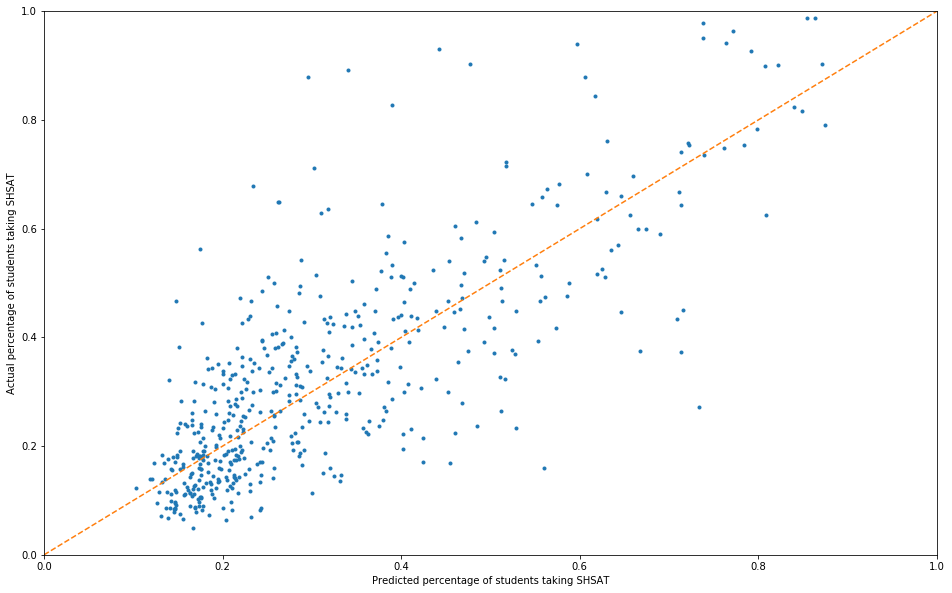

In [31]:
plt.figure(figsize=(16,10))
plt.plot(expit(predictions_p), expit(outputs_p), '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Predicted percentage of students taking SHSAT")  # compare with HS Admission Process applicants
plt.ylabel("Actual percentage of students taking SHSAT");

Text(0,0.5,'Residual logit')

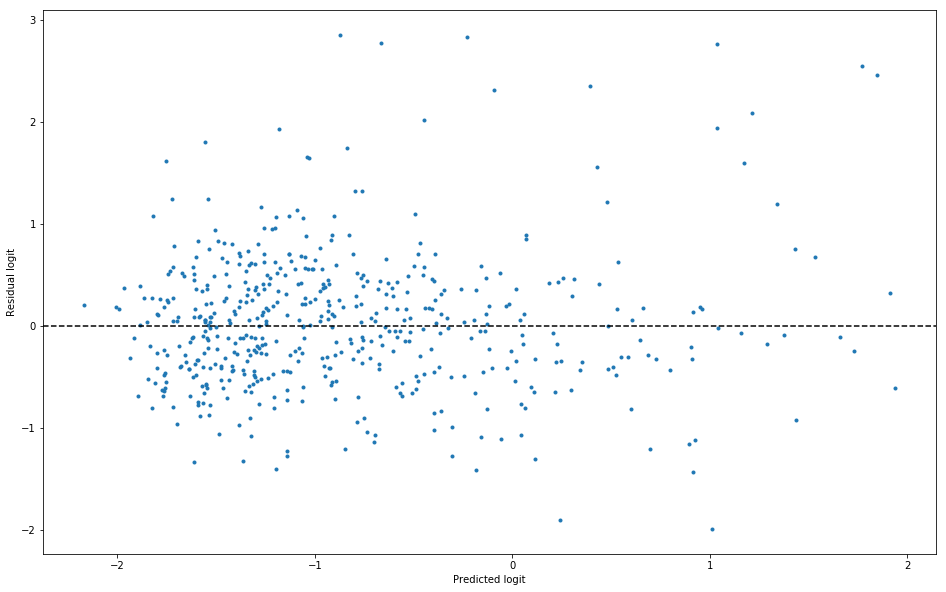

In [32]:
plt.figure(figsize=(16,10))
plt.plot(predictions_p, residuals, '.')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted logit")
plt.ylabel("Residual logit")

## Estimate the gap in various units

### Actual Values

In [13]:
# min and max for schools with 0->5 SHSAT applicants

present = outputs.notnull()
hs_counts = df['# Students in HS Admissions'][~present]

# min values
min_table = pd.DataFrame({
    'logit': -np.inf,
    'pct': 0,
    'cnt': 0,
}, index=hs_counts.index)

# max values
cnt = 5
pct = 5 / hs_counts
odds = pct / (1 - pct)
logit_ = np.log(odds)
max_table = pd.DataFrame({
    'logit': logit_,
    'pct': pct,
    'cnt': cnt,
}, index=hs_counts.index)

# visualize
min_table.join(max_table, lsuffix='min', rsuffix='max').head()

,logitmin,pctmin,cntmin,logitmax,pctmax,cntmax
DBN,,,,,,
01M188,-inf,0,0,-2.379546,0.084746,5
02M225,-inf,0,0,-1.163151,0.238095,5
02M655,-inf,0,0,-1.223775,0.227273,5
03M076,-inf,0,0,-2.379546,0.084746,5
03M149,-inf,0,0,-1.481605,0.185185,5


In [14]:
# values for schools with 6+ SHSAT applicants

present = outputs.notnull()
hs_counts = df['# Students in HS Admissions'][present]

cnt = df['# SHSAT Testers'][present]
pct = cnt / hs_counts
odds = pct / (1 - pct)
logit_ = np.log(odds)

table = pd.DataFrame({
    'logit': logit_,
    'pct': pct,
    'cnt': cnt,
}, index=hs_counts.index)
table.cnt

table.head()

,logit,pct,cnt
DBN,,,
01M034,-2.159484,0.103448,6.0
01M140,-2.319114,0.089552,6.0
01M184,1.160170,0.761364,67.0
01M301,-1.290984,0.215686,11.0
01M332,-1.442384,0.191176,13.0


### Estimated values

In [15]:
hs_counts = df['# Students in HS Admissions']

logit_ = predictions
odds = np.exp(logit_)
pct = odds / (1 + odds)
cnt = pct * hs_counts

exp_table = pd.DataFrame({
    'logit': logit_,
    'pct': pct,
    'cnt': cnt,
}, index=hs_counts.index)
exp_table.head()

,logit,pct,cnt
DBN,,,
01M034,-1.572512,0.171859,9.967794
01M140,-1.631225,0.163663,10.965396
01M184,0.532934,0.630167,55.454716
01M188,-1.624926,0.164527,9.707071
01M301,-1.405411,0.196959,10.044904


### Differences

In [16]:
min_diffs = (min_table - exp_table).dropna()
max_diffs = (max_table - exp_table).dropna()
diffs = (table - exp_table).dropna()

min_diffs.join(max_diffs, lsuffix='min', rsuffix='max').head()

,logitmin,pctmin,cntmin,logitmax,pctmax,cntmax
DBN,,,,,,
01M188,-inf,-0.164527,-9.707071,-0.754620,-0.079781,-4.707071
02M225,-inf,-0.412193,-8.656048,-0.808243,-0.174098,-3.656048
02M655,-inf,-0.160177,-3.523898,0.433135,0.067096,1.476102
03M076,-inf,-0.160402,-9.463690,-0.724303,-0.075656,-4.463690
03M149,-inf,-0.159472,-4.305738,0.180559,0.025713,0.694262


### Join

In [17]:
# students num
hs_counts = df['# Students in HS Admissions'].to_frame()

# actual
actual = pd.DataFrame({
    'Actual Cnt (min)': pd.concat([min_table, table])['cnt'],
    'Actual Cnt (max)': pd.concat([max_table, table])['cnt'],
    'Actual Pct (min)': pd.concat([min_table, table])['pct'],
    'Actual Pct (max)': pd.concat([max_table, table])['pct'],
})

# expected
expected = pd.DataFrame({
    'Predicted Cnt': exp_table['cnt'],
    'Predicted Pct': exp_table['pct'],
})

# difference
difference = pd.DataFrame({
    'Diff Cnt (min)': pd.concat([min_diffs, diffs])['cnt'],
    'Diff Cnt (max)': pd.concat([max_diffs, diffs])['cnt'],
    'Diff Pct (min)': pd.concat([min_diffs, diffs])['pct'],
    'Diff Pct (max)': pd.concat([max_diffs, diffs])['pct'],
#     'Diff Logit (min)': pd.concat([min_diffs, diffs])['logit'],
    'Diff Logit': pd.concat([max_diffs, diffs])['logit'],
})

# join
everything = hs_counts.join(actual).join(expected).join(difference)
everything = everything.sort_values(['Diff Logit'])  # when entry is unkown, we assume 5 students
# logit needs explanation
everything.head()

,# Students in HS Admissions,Actual Cnt (min),Actual Cnt (max),Actual Pct (min),Actual Pct (max),Predicted Cnt,Predicted Pct,Diff Cnt (min),Diff Cnt (max),Diff Pct (min),Diff Pct (max),Diff Logit
DBN,,,,,,,,,,,,
02M408,33.0,9.0,9.0,0.272727,0.272727,24.202615,0.733413,-15.202615,-15.202615,-0.460685,-0.460685,-1.992835
84M336,94.0,15.0,15.0,0.159574,0.159574,52.589193,0.559460,-37.589193,-37.589193,-0.399885,-0.399885,-1.900366
84M353,101.0,0.0,5.0,0.000000,0.049505,25.383446,0.251321,-25.383446,-20.383446,-0.251321,-0.201816,-1.863332
09X117,175.0,0.0,5.0,0.000000,0.028571,24.184993,0.138200,-24.184993,-19.184993,-0.138200,-0.109629,-1.696039
32K554,59.0,22.0,22.0,0.372881,0.372881,42.120238,0.713902,-20.120238,-20.120238,-0.341021,-0.341021,-1.434288


In [18]:
a = df.join(everything[['Diff Cnt (min)']]).reindex(everything.index)
a[(a['% SHSAT Testers'] < 0.2) &
  (a['Borough'] != 'manhattan') &
  (a['Percent Black'] + a['Percent Hispanic'] + a['Percent Other'] >= 0.8)]

,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,# SHSAT Testers,# SHSAT Offers,% SHSAT Testers,% SHSAT Offers,Diff Cnt (min)
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32K162,J.H.S. 162 The Willoughby,0.0,brooklyn,40.706816,-73.919643,0.024,0.035,0.908,0.026,0.007,0.195,0.266,0.299,0.823,293.4257,52.02703,16.216220,0.675676,286.2800,34.000000,8.666667,1.333333,161.0,8.0,NaN,0.049689,NaN,-18.775973
84X482,Dr. Richard Izquierdo Health and Science Chart...,1.0,bronx,40.826933,-73.900593,0.006,0.319,0.640,0.021,0.014,0.115,0.251,0.222,0.841,300.0000,53.91304,17.391300,3.478261,292.6018,36.283190,14.159290,5.309735,110.0,7.0,NaN,0.063636,NaN,-15.439358
29Q259,Pathways College Preparatory School: A College...,0.0,queens,40.705989,-73.752885,0.045,0.850,0.061,0.004,0.040,0.000,0.162,0.080,0.393,309.8333,46.15385,39.743590,2.564103,282.0000,29.333330,6.666667,1.333333,73.0,6.0,NaN,0.082192,NaN,-11.690162
10X037,P.S. X037 - Multiple Intelligence School,0.0,bronx,40.877935,-73.913694,0.018,0.231,0.724,0.014,0.013,0.185,0.268,0.295,0.760,305.0800,48.00000,26.000000,4.000000,313.0612,44.897960,32.653060,6.122449,70.0,6.0,NaN,0.085714,NaN,-10.970738
09X004,P.S./M.S. 004 Crotona Park West,0.0,bronx,40.841758,-73.897943,0.007,0.547,0.420,0.009,0.017,0.128,0.272,0.499,0.909,312.0189,43.39623,26.415090,15.094340,316.1481,27.777780,37.037040,14.814810,62.0,7.0,NaN,0.112903,NaN,-11.577633
07X221,South Bronx Preparatory: A College Board School,0.0,bronx,40.813612,-73.920851,0.004,0.210,0.751,0.025,0.010,0.082,0.278,0.199,0.906,304.9556,56.66667,28.888890,2.222222,295.2222,42.222220,13.333330,2.222222,97.0,8.0,NaN,0.082474,NaN,-12.370560
19K171,I.S. 171 Abraham Lincoln,0.0,brooklyn,40.685852,-73.869434,0.057,0.109,0.779,0.020,0.035,0.262,0.190,0.225,0.723,299.0853,41.86047,27.131780,4.651163,288.6028,41.134750,9.219858,0.000000,151.0,11.0,NaN,0.072848,NaN,-16.897668
19K422,Spring Creek Community School,0.0,brooklyn,40.657266,-73.874064,0.027,0.719,0.232,0.004,0.018,0.018,0.237,0.271,0.732,306.2308,61.53846,23.076920,3.076923,282.8571,26.984130,7.936508,1.587302,69.0,6.0,NaN,0.086957,NaN,-7.857126
09X219,I.S. 219 New Venture School,0.0,bronx,40.833493,-73.903951,0.006,0.395,0.582,0.010,0.007,0.241,0.283,0.310,0.916,294.0947,56.84211,9.473684,3.157895,280.0000,31.683170,4.950495,0.990099,107.0,7.0,NaN,0.065421,NaN,-9.597713


In [19]:
a.loc['32K162']

School Name                               J.H.S. 162 The Willoughby
Charter School?                                                   0
Borough                                                    brooklyn
Latitude                                                    40.7068
Longitude                                                  -73.9196
Percent Asian                                                 0.024
Percent Black                                                 0.035
Percent Hispanic                                              0.908
Percent White                                                 0.026
Percent Other                                                 0.007
Percent English Language Learners                             0.195
Percent Students with Disabilities                            0.266
Percent of Students Chronically Absent                        0.299
Economic Need Index                                           0.823
Mean Scale Score - ELA                          

## Pandas format

In [20]:
format_dict = {
    'logit': '{:.2f}',
    'pct':   '{:.0%}',
    'cnt':   '{:.0f}',
}
table.head(10).style.format(format_dict)

,logit,pct,cnt
DBN,,,
01M034,-2.16,10%,6
01M140,-2.32,9%,6
01M184,1.16,76%,67
01M301,-1.29,22%,11
01M332,-1.44,19%,13
01M378,-1.40,20%,19
01M450,-1.58,17%,16
01M539,2.53,93%,126
01M839,0.10,52%,66


---

**TODO**

Link this image with actual data

![](../data/output/shsat_offers_by_grade.png)

---

In [ ]:
# percentage values
actual_pct = expit(outputs)
estimated_pct = expit(predictions)
residual_pct = actual_pct - estimated_pct

# absolute values (total count)
hs_admissions_counts = hs_admissions_counts.reindex(outputs.index)
actual_cnt = actual_pct * hs_admissions_counts
estimated_cnt = estimated_pct * hs_admissions_counts
residual_cnt = actual_cnt - estimated_cnt

In [ ]:
reg_results = pd.DataFrame({
    'Actual #': actual_cnt,
    'Estimated #': np.round(estimated_cnt),
    'Difference #': np.round(residual_cnt),
    
    'Actual %': actual_pct,
    'Estimated %': estimated_pct,
    'Difference %': residual_pct,
})

# reg_results.loc[:, :'Difference #'] = reg_results.loc[:, :'Difference #'].applymap(lambda x: "{:.0f}".format(x))
# reg_results.loc[:, 'Actual %':] = reg_results.loc[:, 'Actual %':].applymap(lambda x: "{:.0%}".format(x))

reg_results.head()

In [ ]:
d = pd.read_pickle('../data/process/schools2017.pkl')
d = d.loc[:, :'# Students in HS Admissions']
d = pd.concat([d, reg_results], axis=1, sort=True)
d.head()

In [ ]:
d[(d['Borough'] == 'brooklyn') & (d['Actual %'] <= 0.15) & (d['Percent White'] < 0.2)].sort_values('Difference %')

## One school example

In [ ]:
d.loc['19K422']

This school was selected among the schools with the biggest difference in percentage. Characteristics:

- Located on Brooklyn
- Population mostly Black/Hispanic

Problem: Chronic Absenteeism seems to be being understimated. It is probably really correlated with other features, and we can't do much about it.